In [1]:
import yaml
import sys, os

from IPython.display import Image, SVG

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.utils import *
from src.svg_quality_checks import *
from src.gpt_wrappers import *
from src.langchain_database import *

# show svg 
def show_svg(file):
    display(SVG(file))

# load yaml config
with open("../config.yml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
import openai
import wandb

openai.api_key = config["OPENAI_KEY"]
os.environ["OPENAI_API_KEY"] = config["OPENAI_KEY"]

run = wandb.init(
    project=config['WANDB_PROJECT'], 
    entity=config['WANDB_ENTITY']
)

results_table = wandb.Table(
    columns=[
                "system_prompt", 
                "question_prompt",
                "input_svg",
                "output_svg",
                "input_svg_code",
                "output_svg_code",
                "valid_check",
                "size_check"
    ]
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rachnogstyle (penpot_protoprompt). Use `wandb login --relogin` to force relogin


In [3]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAIChat
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

## Create OpenAI index
download the data in separate folders in the "training_data_raw folder"

i.e. "training_data_raw/Footer" ...

In [4]:
sources = create_sources_from_files(path = "../training_data_raw", 
                                    description = "This is the SVG for the graphic object", 
                                    style = "Material Design 3"
                                    )
chunks = create_chunks_from_the_sources(sources, 
                                        separators = [], 
                                        chunk_size = 2048, 
                                        chunk_overlap = 0
                                        )
index = create_index_from_the_chunks(chunks)

# Running experiments

## Case 1: no SVG input

In [5]:
system_prompt = \
"""
    You are an expert in design in different fields, you use different vector graphics tools.
    You deal professionally with SVG files, you know how to create complex design with them.
    Your main jon is to complete design systems and tokens based on the initial inputs. 
    These initial inputs are SVG files that can consist of multiple layers, groups, paths, etc.
    They can be different elements as icons, logos, buttons, checkboxes, etc. \n
"""

question_prompt = \
"""=========
TASK:
Generate SVG of {question}.
Keep it as short and optimized as you can, be limited by the tokens.
Start with <svg ... and end with </svg>: 
=========
SIMILAR ELEMENTS:
{summaries}
=========
SVG:"""

template = system_prompt + question_prompt

prompt = PromptTemplate(template=template, input_variables=["summaries", "question"])
chain = load_qa_with_sources_chain(OpenAIChat(temperature=0.9, model_name="gpt-3.5-turbo"), prompt=prompt)

question = "Search button and text field, size 500 x 100"

answer = chain(
            {
                "input_documents": index.similarity_search(question, k=3),
                "question": question,
            },
            return_only_outputs=True,
        )["output_text"]

print(answer)
print("Quality check:", validate_svg(answer), get_svg_size(answer))

/Users/oleksandrhonchar/miniforge3/lib/python3.9/site-packages/langchain/llms/openai.py:676: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


<svg width="500" height="100" viewBox="0 0 500 100" xmlns="http://www.w3.org/2000/svg">
  <rect x="0" y="0" width="40" height="40" rx="4" fill="#3F51B5"/>
  <circle cx="30" cy="30" r="12" fill="#FFFFFF"/>
  <path d="M 40 40 L 48 48" stroke="#FFFFFF" stroke-width="2" stroke-linecap="round"/>
  <rect x="60" y="10" width="360" height="40" rx="20" fill="#FFFFFF" stroke="#757575" stroke-width="2"/>
  <path d="M 410 30 L 450 70" stroke="#3F51B5" stroke-width="2" stroke-linecap="round"/>
  <path d="M 450 30 L 410 70" stroke="#3F51B5" stroke-width="2" stroke-linecap="round"/>
  <text x="90" y="35" font-size="18" font-weight="500" fill="#3F51B5" font-family="sans-serif" dominant-baseline="middle">Search</text>
  <rect x="90" y="60" width="320" height="2" fill="#757575"/>
  <text x="90" y="75" font-size="14" fill="#757575" font-family="sans-serif" dominant-baseline="middle">Type your search query here</text>
</svg>
Quality check: True (500.0, 100.0)



test_optimized.svg:
Done in 25 ms!
0.869 KiB - 19.7% = 0.698 KiB


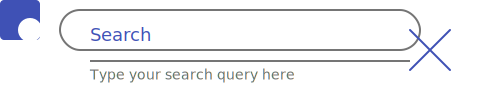

In [6]:
FILENAME = 'test'
save_gpt_answer_as_svg(answer, FILENAME)
show_svg(f'../generated_data/{FILENAME}_optimized.svg')

In [7]:
results_table.add_data(
    *[
        system_prompt, question, 
        wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'), wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'),
        "", answer,
        validate_svg(answer), get_svg_size(answer)
    ]
)

## Case 2: SVG input


segmented_buttons_short_optimized.svg:
Done in 104 ms!
13.162 KiB - 70.3% = 3.909 KiB


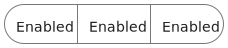

In [8]:
FILENAME = "segmented_buttons_short"
svg_original = load_raw_svg_optimize_clean(FILENAME)
show_svg(f'../data/svgs/{FILENAME}_optimized.svg')

In [11]:
system_prompt = \
"""
    You are an expert in design in different fields, you use different vector graphics tools.
    You deal professionally with SVG files, you know how to create complex design with them.
    Your main jon is to complete design systems and tokens based on the initial inputs. 
    These initial inputs are SVG files that can consist of multiple layers, groups, paths, etc.
    They can be different elements as icons, logos, buttons, checkboxes, etc. \n
"""

question_prompt = \
"""=========
TASK:
Generate SVG of {question}.
Keep it as short and optimized as you can, be limited by the tokens.
Start with <svg ... and end with </svg>: 
=========
SIMILAR ELEMENTS:
{summaries}
=========
SVG:"""

template = system_prompt + question_prompt

prompt = PromptTemplate(template=template, input_variables=["summaries", "question"])
chain = load_qa_with_sources_chain(OpenAIChat(temperature=0.9, model_name="gpt-3.5-turbo"), prompt=prompt)

question = f"Segmented buttons the same as in the following SVG but middle button is green {svg_original}"

answer = chain(
            {
                "input_documents": index.similarity_search(question, k=1),
                "question": question,
            },
            return_only_outputs=True,
        )["output_text"]

print(answer)
print("Quality check:", validate_svg(answer), get_svg_size(answer))

<svg width="228" height="48" fill="none" xmlns="http://www.w3.org/2000/svg">
  <g clip-path="url(#a)">
    <rect width="228" height="48" rx="0" ry="0" class="frame-background" />
    <rect width="73" height="40" x="151" y="4" class="frame-background" rx="0" ry="0" />
    <rect width="74" height="40" x="77" y="4" class="frame-background" rx="0" ry="0" />
    <rect width="73" height="40" x="4" y="4" class="frame-background" rx="0" ry="0" fill="#00C853" />
    <defs>
      <path id="buttonPath" d="M0 0h73v40H0a20 20 0 0 1-20-20 20 20 0 0 1 20-20z" />
    </defs>
    <use href="#buttonPath" x="4" y="4" fill="#FFF" stroke="#79747.00E" stroke-width="2" />
    <use href="#buttonPath" x="77" y="4" fill="#FFF" stroke="#79747.00E" stroke-width="2" />
    <use href="#buttonPath" x="151" y="4" fill="#FFF" stroke="#79747.00E" stroke-width="2" />
    <text x="20" y="31.85" class="fills" dominant-baseline="ideographic" lengthAdjust="spacingAndGlyphs" style="text-transform:none;font-family:Roboto;lett


segmented_buttons_short_optimized.svg:
Done in 41 ms!
1.912 KiB - 8.9% = 1.742 KiB


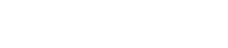

In [12]:
save_gpt_answer_as_svg(answer, FILENAME)
show_svg(f'../generated_data/{FILENAME}_optimized.svg')

In [13]:
results_table.add_data(
    *[
        system_prompt, question, 
        wandb.Html(f'../data/svgs/{FILENAME}_optimized.svg'), wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'),
        svg_original, answer,
        validate_svg(answer), get_svg_size(answer)
    ]
)

## Log everything

In [14]:
run.log({"results_table": results_table})